# 1. Import Libraries 

In [53]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from mlxtend.frequent_patterns import apriori, association_rules
from ydata_profiling import ProfileReport


# 2. Read grocery data 

In [54]:
sales_data = pd.read_csv('Groceries_dataset.csv')
sales_data = pd.DataFrame(sales_data)
sales_data['Date'] = pd.to_datetime(sales_data['Date'],format='%d-%m-%Y', errors='coerce')
sales_data.head()

,Member_number,Date,itemDescription
0,1808,2015-07-21,tropical fruit
1,2552,2015-01-05,whole milk
2,2300,2015-09-19,pip fruit
3,1187,2015-12-12,other vegetables
4,3037,2015-02-01,whole milk


# 3. Data Profiling

In [55]:
data_report = ProfileReport(sales_data)
data_report.to_file('sales_data_report.html')

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

100%|██████████| 3/3 [00:00<00:00, 12.85it/s]


Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/matplotlib/cbook.py:684: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  x = np.array(x, subok=True, copy=copy)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/matplotlib/cbook.py:684: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  x = np.array(x, subok=True, copy=copy)


Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

# 4. Analyse the Frequency and Uniqueness of Products

In [56]:
total_unique_items = sales_data['itemDescription'].nunique()
print('Total unique products:',total_unique_items)

# show the product frequencies 
item_frequencies = sales_data['itemDescription'].value_counts().reset_index()
item_frequencies.columns = ['itemDescription', 'frequency']
item_frequencies = item_frequencies.sort_values('frequency', ascending=False)
item_frequencies

Total unique products: 167


,itemDescription,frequency
0,whole milk,2502
1,other vegetables,1898
2,rolls/buns,1716
3,soda,1514
4,yogurt,1334
...,...,...
162,rubbing alcohol,5
163,bags,4
164,baby cosmetics,3
165,kitchen utensil,1


# 5. Visualize the top 20 most frequent products

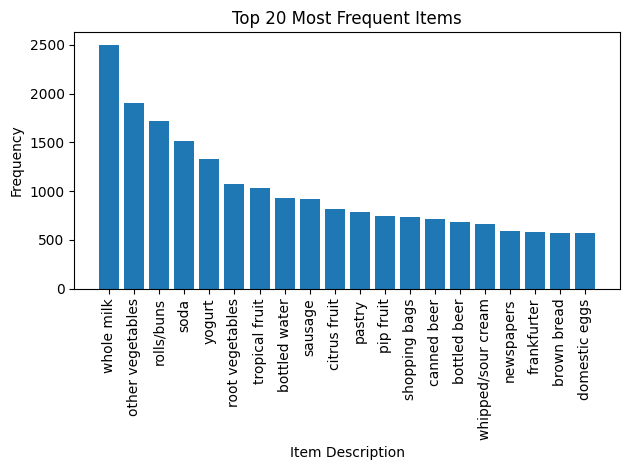

In [57]:
# plot the most frequent top 20 items
%matplotlib inline
plt.Figure(figsize=(12, 6))
plt.bar(item_frequencies['itemDescription'][:20], item_frequencies['frequency'][:20])
plt.xticks(rotation=90)
plt.xlabel('Item Description')
plt.ylabel('Frequency')
plt.title('Top 20 Most Frequent Items')
plt.tight_layout()
plt.show()

In [58]:
grouped_data = sales_data.groupby(['Date','Member_number'])['itemDescription'].agg(lambda x: ','.join(x)).reset_index()
grouped_data

,Date,Member_number,itemDescription
0,2014-01-01,1249,"citrus fruit,coffee"
1,2014-01-01,1381,"curd,soda"
2,2014-01-01,1440,"other vegetables,yogurt"
3,2014-01-01,1659,"specialty chocolate,frozen vegetables"
4,2014-01-01,1789,"hamburger meat,candles"
...,...,...,...
14958,2015-12-30,3738,"onions,flour"
14959,2015-12-30,3971,"brown bread,bottled beer"
14960,2015-12-30,4058,"domestic eggs,cream cheese"
14961,2015-12-30,4565,"canned beer,canned beer"


In [59]:
sales_data['Member_number'].unique().shape[0]

3898

# 6. Create a basket matrix

In [60]:
# create a basket matrix

def create_basket(data):
    basket = (data.groupby(['Member_number', 'itemDescription'])['itemDescription']
              .count().unstack().reset_index().fillna(0)
              .set_index('Member_number'))
    basket = basket.applymap(lambda x: 1 if x > 0 else 0)
    return basket

# 7. Apply apriori algorithm to find frequent itemsets

In [61]:
# Generate frequent items sets and association rules

basket = create_basket(sales_data)
freq_items = apriori(basket, min_support=0.10, use_colnames=True)

min_lift = 1
rules = association_rules(freq_items, metric='lift',min_threshold=min_lift).sort_values('lift', ascending=False)

/var/folders/yn/3hhy0_3d3w7bfpvchs0d2c440000gn/T/ipykernel_83219/2486241466.py:7: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  basket = basket.applymap(lambda x: 1 if x > 0 else 0)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/mlxtend/frequent_patterns/fpcommon.py:161: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(


In [62]:
# Filter rules based on confidence and support
min_support = 0.10
min_confidence = 0.4
filtered_rules = rules[(rules['confidence']>=min_confidence) & (rules['support']>=min_support)].copy()
filtered_rules = filtered_rules.sort_values('lift', ascending=False)

# display results 
filtered_rules.head(10)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,representativity,leverage,conviction,zhangs_metric,jaccard,certainty,kulczynski
24,(yogurt),(whole milk),0.282966,0.458184,0.150590,0.532185,1.161510,1.0,0.020940,1.158185,0.193926,0.254996,0.136580,0.430426
0,(bottled water),(whole milk),0.213699,0.458184,0.112365,0.525810,1.147597,1.0,0.014452,1.142615,0.163569,0.200825,0.124815,0.385526
18,(sausage),(whole milk),0.206003,0.458184,0.106978,0.519303,1.133394,1.0,0.012591,1.127146,0.148230,0.191989,0.112804,0.376393
8,(yogurt),(other vegetables),0.282966,0.376603,0.120318,0.425204,1.129050,1.0,0.013752,1.084553,0.159406,0.223121,0.077961,0.372343
12,(rolls/buns),(whole milk),0.349666,0.458184,0.178553,0.510638,1.114484,1.0,0.018342,1.107190,0.157955,0.283734,0.096813,0.450168
2,(rolls/buns),(other vegetables),0.349666,0.376603,0.146742,0.419663,1.114335,1.0,0.015056,1.074197,0.157772,0.253209,0.069072,0.404654
7,(whole milk),(other vegetables),0.458184,0.376603,0.191380,0.417693,1.109106,1.0,0.018827,1.070564,0.181562,0.297448,0.065913,0.462934
6,(other vegetables),(whole milk),0.376603,0.458184,0.191380,0.508174,1.109106,1.0,0.018827,1.101643,0.157802,0.297448,0.092265,0.462934
22,(tropical fruit),(whole milk),0.233710,0.458184,0.116470,0.498353,1.087672,1.0,0.009388,1.080076,0.105189,0.202407,0.074139,0.376276
16,(root vegetables),(whole milk),0.230631,0.458184,0.113135,0.490545,1.070630,1.0,0.007464,1.063522,0.085746,0.196524,0.059728,0.368733


# 8. save the results to a CSV file

In [63]:
# save results to csv
required_cols = ['antecedents', 'consequents', 'support', 'confidence', 'lift']
filtered_rules = filtered_rules[required_cols]
filtered_rules.to_csv('association_rules.csv', index=False)

# 9. Visualize the association rules

/var/folders/yn/3hhy0_3d3w7bfpvchs0d2c440000gn/T/ipykernel_83219/966430401.py:6: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


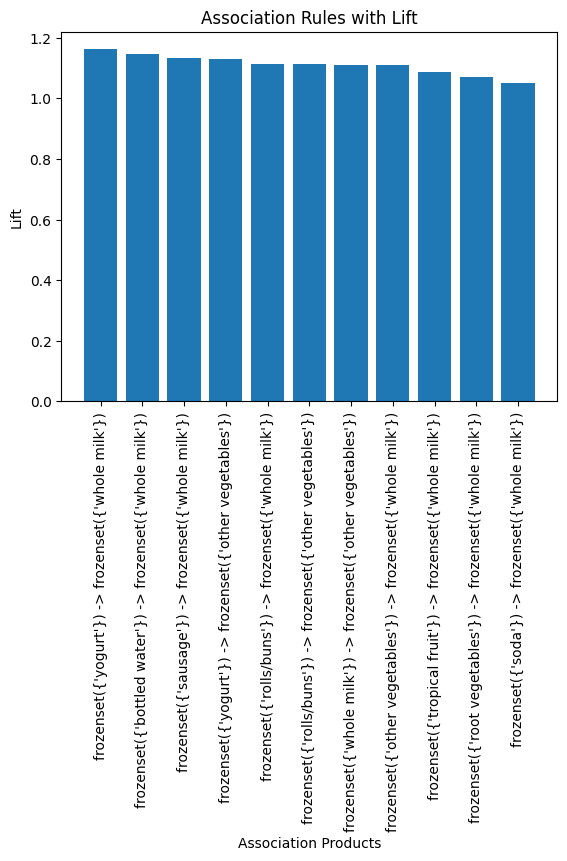

In [64]:
plt.bar(filtered_rules['antecedents'].astype(str) + ' -> ' + filtered_rules['consequents'].astype(str), filtered_rules['lift'])
plt.xticks(rotation=90)
plt.xlabel('Association Products')
plt.ylabel('Lift')
plt.title('Association Rules with Lift')
plt.tight_layout()